# Notebook with CVAE model and conditionning over day of the week, month and temperature

## Loading Libraries 

In [51]:
#import external libraries
import sys
import os
import datetime
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
import seaborn as sn
from scipy import stats
import cv2 #from open-cv, to convert array to images

In [2]:
#paths in git

#root git folder 
path_main_folder = '/home/goubetcle/Documents/CVAE/marota_cvae'
#path_main_folder = '/home/jovyan'#specify the root folder of the git repo

#add  to path root git folder 
sys.path.append(path_main_folder)
#add  to path source code folder
sys.path.append(path_main_folder+'/src')

In [183]:
#import class and methods from src
from keras import backend as K
from CVAE.callbacks import NEpochLogger,callbackWeightLoss
#from CVAE.cvae import compile_cvae, run_cvae
from CVAE.cvae_model import CVAE, CVAE_emb, CAE
from conso.load_shape_data import *  

import Visualisation.buildProjector
from Visualisation.buildProjector import *
from FeaturesScore.scoring import *
#from conso.load_shape_data import get_x_conso_autoencoder
from conso.conso_helpers import plot_latent_space_projection, pyplot_latent_space_projection_temp, pyplot_latent_space_projection_error
from sklearn.manifold import TSNE
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
#directories to store trained model and the related projector

log_dir_projector=path_main_folder+"/notebooks/logs/Expe3/CVAE_W_M_T/projector"
log_dir_model=path_main_folder+"/notebooks/logs/Expe3/CVAE_W_M_T//model"
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)

# Table of contents:
- Load Data
- Make Training Set
- Define and Train Model
- Build Projector
- Compute Feature Scores in latent space
- Study reconstruction Error
- Study Holidays prediction
- Detect atypical events
- Conclusion

# Load dataset 

In [5]:
# Load dataframe
path_data = os.path.join(path_main_folder, 'data')
dataset_csv = os.path.join(path_data, "dataset.csv")
x_conso = pd.read_csv(dataset_csv, sep=",",)
x_conso.ds = pd.to_datetime(x_conso.ds)

In [6]:
#drop indices column
x_conso=x_conso.drop(columns=x_conso.columns[0],axis=1)

In [7]:
#Visualize data frame head
x_conso.head(5)

,ds,consumption_France,temperature_France,is_holiday_day
0,2012-12-28 00:00:00,59679.0,8.817600,0.0
1,2012-12-28 00:30:00,58103.0,8.690875,0.0
2,2012-12-28 01:00:00,55354.0,8.564150,0.0
3,2012-12-28 01:30:00,55196.0,8.440525,0.0
4,2012-12-28 02:00:00,54324.0,8.316900,0.0


# Make training set of daily electrical consumption profiles and conditions 
In this experiment, we use some conditions from expert knowledge we previosuly recovered (temperature, month, days of the week) to learn a new residual latent space.  

In [8]:
name_set_plot = 'train'
version = '-v1'
nPoints=1830

In [9]:
dict_xconso = {'train': x_conso}

In [10]:
# Normalize input variables
type_scaler = 's'
dict_xconso, _ = normalize_xconso(dict_xconso, type_scaler = 'standard')

['consumption_France']


Give the features on which to condition

In [12]:
type_x = ['conso']
type_cond = ['day','month','temperature']
dataset = get_dataset_autoencoder(dict_xconso=dict_xconso, type_x=type_x, list_cond=type_cond)

day (1830, 7)
month (1830, 12)
temperature (1830, 48)
(1830, 67)


In [13]:

nPoints=dataset['train']['x'][1].shape[0]

#get conditions in array
days_emb =dataset['train']['x'][1][:,0:7]
month_emb =dataset['train']['x'][1][:,7:19]
temp_emb=dataset['train']['x'][1][:,19:]
to_emb=dataset['train']['x'][1]

x = dataset['train']['x'][0]

dataset['train']['x'] = [x,days_emb,month_emb,temp_emb]

In [14]:
np.shape(temp_emb)

(1830, 48)

In [15]:
calendar_info = pd.DataFrame(dataset[name_set_plot]['ds'])
calendar_info['month'] = calendar_info.ds.dt.month
calendar_info['weekday'] = calendar_info.ds.dt.weekday
calendar_info['is_weekday'] = (calendar_info.weekday < 5).apply(lambda x:int(x))
calendar_info = pd.merge(calendar_info, x_conso[['ds', 'is_holiday_day']], on='ds', how ='left')
calendar_info.loc[calendar_info['is_holiday_day'].isna(),'is_holiday_day'] = 0

In [16]:
meteo1_csv = os.path.join(path_data, "meteo_events.csv")
meteo2_csv = os.path.join(path_data, "meteo_events_2.csv")

meteo_events1 = pd.read_csv(meteo1_csv)
meteo_events2 = pd.read_csv(meteo2_csv)
meteo_events = meteo_events1.append(meteo_events2)
calendar_info=calendar_info.assign(snow=0, floods=0, storm=0, hurricane=0, rain=0, cold=0, hot=0)

from datetime import *
for k in range(meteo_events.shape[0]):
    day = datetime.strptime(meteo_events.iloc[k,0],'%Y-%m-%d')
    cld = np.asarray(calendar_info.ds.dt.date)
    row = np.where(cld==day.date())[0]
    calendar_info.iloc[row,5:]+=np.asarray(meteo_events.iloc[k,2:-1])
    duration = int(meteo_events.iloc[k,1])
    if duration != 0:
        for i in range(duration):
            day_inc = timedelta(days=i+1)+day
            cld = np.asarray(calendar_info.ds.dt.date)
            row = np.where(cld==day_inc.date())[0]
            calendar_info.iloc[row,5:]+=np.asarray(meteo_events.iloc[k,2:-1])

calendar_info.iloc[:,5:] = 1*(calendar_info.iloc[:,5:]>0)

# Build and train model CVAE

In [17]:
#on sauvegarde le dataset
path_out = log_dir_model

In [18]:
# Parameters for autoencoder
e_dims=[48,35,24,12]#encoder dim
d_dims=[48,35,24,12]#decoder dim. Dense Blocks in skip connections can make the dimensions bigger when layers are concatenated with the previous one
to_emb_dim=[7,12,48] #input dimensions for conditions
cond_pre_dim = 0
input_dim = dataset['train']['x'][0].shape[1]
z_dim= 4
lambda_val = 0.4 #hyper-parameter which value was selected after cross-validation

In [19]:
name_model = 'cvae_conso-W_M_T_30min-journalier'
#name_model = 'cvae_classification'

In [53]:
#if needs to relaod model classes after modification wothout restarting the kernel

import CVAE.cvae_model
import CVAE.callbacks
import importlib
importlib.reload(CVAE.cvae_model)
importlib.reload(CVAE.callbacks)

%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
Lambda = K.variable(lambda_val, dtype='float32')
model = CVAE.cvae_model.CVAE_emb(input_dim=input_dim,
                  e_dims=e_dims, 
                  d_dims=d_dims, 
                  cond_pre_dim=cond_pre_dim,
                  z_dim=z_dim, 
                  beta=Lambda,
                  name=name_model, 
                  output=path_out,
                 to_emb_dim=to_emb_dim,
                 emb_dims=[[5,3],[6,3],[12,4]], emb_to_z_dim=[5,5],is_L2_Loss=False,has_BN=2)#these dimensions define the dimension layer of the conitional network

Instructions for updating:
Colocations handled automatically by placer.


W0620 14:12:04.025936 139724771710272 deprecation.py:323] From /home/goubetcle/.local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


5
L1 loss
False
L1 loss
False
L1 loss
False
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
emb_input_0 (InputLayer)        (None, 7)            0                                            
__________________________________________________________________________________________________
emb_input_1 (InputLayer)        (None, 12)           0                                            
__________________________________________________________________________________________________
emb_input_2 (InputLayer)        (None, 48)           0                                            
__________________________________________________________________________________________________
x_true (InputLayer)             (None, 48)           0                                            
________________________________________________

### Trainning model 

In [22]:
from keras.callbacks import TensorBoard
from time import time

#embeddingsMetadata = {'dec_dense_0': 'metadata.tsv'}
tensorboard = TensorBoard(log_dir="logs/{}".format(name_model +str(time())),write_graph=True)#,write_images=True,embeddings_freq=10, embeddings_layer_names=['dec_dense_0'],embeddings_metadata= embeddingsMetadata)


We start a pre-training phase with a constant and high lambda to properly learn the conditional embedding

In [23]:
import warnings
warnings.filterwarnings('ignore')

lambda_decreaseRate=0.0
lambda_min=0.01 #p

#Turn it to True to train the model. Otherwise you can directly load on already trained model below
runTraining=False
runBatchCallback=True #In this callback we compute feature scores which is a bit long

if runTraining:#Training a neural network requires some computing power and the CPUs in MyBinder environment can be a bit slow. If you don't use callbacks it can be faster also 
    
    if runBatchCallback:
        out_batch = NEpochLogger(x_train_data=dataset['train']['x'], display=100,x_conso=x_conso,calendar_info=calendar_info)
        model.main_train(dataset, training_epochs=1500, batch_size=32, verbose=0,callbacks=[tensorboard,out_batch],validation_split=0.1)
    else:
        #use verbose=1 to see logs of training at every epoch
        model.main_train(dataset, training_epochs=1500, batch_size=32, verbose=0,callbacks=[tensorboard],validation_split=0.1)


We now continue with a learning phase for better reconstruction and refine the similarities between instances. It can be seen as a diffusion phase. We smoothly decese the lambda after each epoch.

In [24]:
lambda_decreaseRate=0.001 #parameter by default

if runTraining:
    weightLoss=callbackWeightLoss(lambda_val,lambda_decreaseRate,lambda_min)
    if runBatchCallback:
        model.main_train(dataset, training_epochs=2000, batch_size=32, verbose=0,callbacks=[tensorboard,out_batch,weightLoss],validation_split=0.1)
    else:
        model.main_train(dataset, training_epochs=2000, batch_size=32, verbose=0,callbacks=[tensorboard,weightLoss],validation_split=0.1)


DimsImportance=[1264   1181     11   38] Only 2 dimensions are significant here (each term is the sum of absolute values in each direction for the all the datapoints.
There is no significant overfitting when comparing training error to validation error. This will be confimed later on specific examples.

In [25]:
if runTraining:
    with open(os.path.join(log_dir_model,name_model,"config.txt"),'w') as file: 
        file.write(str(cond_pre_dim) + '\n')
        #file.write(str(emb_dims) + '\n')
        file.write(str(e_dims) + '\n') 
        file.write(str(d_dims) + '\n') 
        file.write(str(z_dim) + '\n')
        file.write(str(Lambda) + '\n')

In [26]:
#sauvegarde du dataset associé
if runTraining:
    name_dataset = 'dataset.pickle'

    with open( os.path.join(log_dir_model,name_model, name_dataset), "wb" ) as file:
        pickle.dump( dataset, file )

## Loading model 

In [27]:
model.load_model(os.path.join(path_out, name_model, 'models'))

In [28]:
emb_inputs=[days_emb,month_emb,temp_emb]
emb_ouputs = model.embedding_enc.predict(emb_inputs)

#cond_pre=day_emb
#cond = np.concatenate((cond_pre, emb_ouputs), axis=1)
cond  = emb_ouputs
x_input = dataset['train']['x'][0]

input_encoder = [x_input,cond]

In [29]:
x_encoded = model.encoder.predict(input_encoder)[0]
x_hat = model.cvae.predict(x=dataset['train']['x'])[0]

# Analysis of the latent space with the construction of a tensorboard projector

In [30]:
includeConsumptionProfileImages=True #can take a bit longer to create and load in tensorboard projector, but it looks better in the projector
if includeConsumptionProfileImages:
    nPoints=1500 #if you want to visualize images of consumption profiles and its recontruction in tensorboard, there is a maximum size that can be handle for a sprite image. 1830 is  
    x_encoded_reduced=x_encoded[0:nPoints,]
    images=createLoadProfileImages(x,x_hat,nPoints)
else:
    nPoints=1830

<Figure size 432x288 with 0 Axes>

In [30]:
if includeConsumptionProfileImages:
    sprites=images_to_sprite(images)
    cv2.imwrite(os.path.join(log_dir_projector, 'sprite_4_classes.png'), sprites)

In [31]:

writeMetaData(log_dir_projector,x_conso,calendar_info,nPoints,has_Odd=False)
if includeConsumptionProfileImages:
    buildProjector(x_encoded_reduced,images=images, log_dir=log_dir_projector)
else:
    buildProjector(x_encoded,images=None, log_dir=log_dir_projector)

In [32]:
log_dir_projector

'/home/goubetcle/Documents/CVAE/marota_cvae/notebooks/logs/Expe3/CVAE_W_M_T/projector'

It is possible to explore the resulting latent projection with tensorboard. You should easily visualize holidays and similar non-working days: like the Christmas Week or days happening before or after holidays

# Predict Features in latent space

In [31]:
df_noCond_VAE=predictFeaturesInLatentSPace(x_conso,calendar_info,x_encoded)

9.481919041666664
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.878152  0.383218  0.435238        0.160000     0.252598
random model    0.511729  0.137558  0.070602        0.036364    -0.383574


We can notice that for the conditions passed (W-M-T), their recovery score in the residual latent space is closed to random. On the other hand, the recovery score of holidays is now high. So the residual latent space is now much more dependant over this feature: holidays are now well-represented in this representation.  

In [194]:
factors = calendar_info.iloc[:,1:5].copy()
factors.describe()

,month,weekday,is_weekday,is_holiday_day
count,1830.000000,1830.000000,1830.000000,1830.000000
mean,6.535519,3.003279,0.713661,0.030055
std,3.455188,2.000817,0.452173,0.170784
min,1.000000,0.000000,0.000000,0.000000
25%,4.000000,1.000000,0.000000,0.000000
50%,7.000000,3.000000,1.000000,0.000000
75%,10.000000,5.000000,1.000000,0.000000
max,12.000000,6.000000,1.000000,1.000000


In [195]:
columns_x = x_conso.columns
conso_idx = np.argmax(['consumption' in c for c in x_conso.columns])
temp_idx = np.argmax(['temperature' in c for c in x_conso.columns])
dates = np.unique(x_conso['ds'].dt.date)
temperatureMean=np.asarray([np.mean(x_conso[columns_x[temp_idx]].iloc[np.where(x_conso['ds'].dt.date==dates[k])]) for k in range(dates.shape[0])])

In [196]:
factorMatrix = np.c_[factors.values,temperatureMean]

In [197]:
factorDesc={
    'month':'category',
    'weekday':'category',
    'is_weekday':'category',
    'is_holiday_day':'category',
    'temperature':'regressor'
}

In [198]:
factorDesc['weekday']

'category'

In [199]:
model_eval, importanceMatrix =evaluateLatentCode(x_conso, x_encoded, factorMatrix, factorDesc)

In [200]:
print((model_eval['disentanglement'].shape))
model_eval.keys()

(4,)


dict_keys(['informativeness', 'disentanglement', 'compactness', 'mean_disentanglement'])

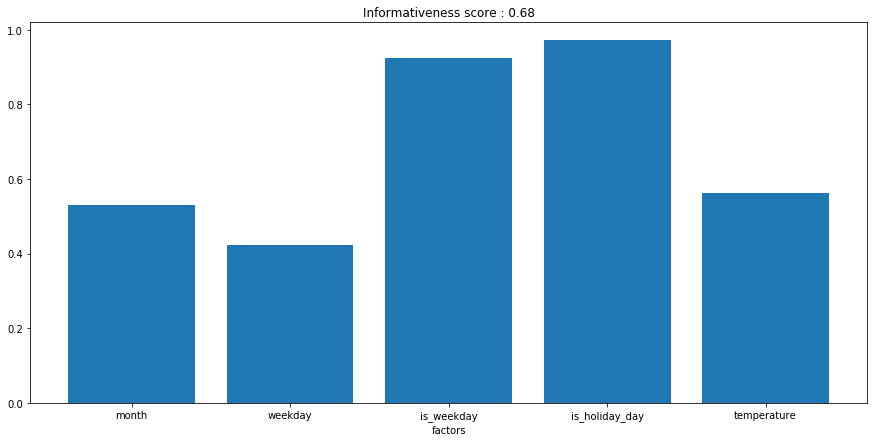

In [207]:
plt.figure(figsize=(15,7))
plt.bar(factorDesc.keys(),model_eval['informativeness'])
plt.xlabel('factors')
plt.title('Informativeness score : %.2f'%np.mean(model_eval['informativeness']));

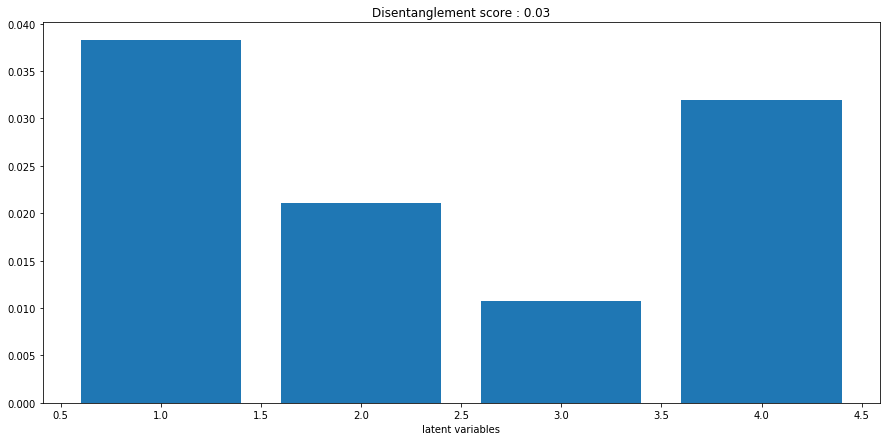

In [205]:
plt.figure(figsize=(15,7))
plt.bar(np.arange(z_dim)+1,model_eval['disentanglement'])
plt.xlabel('latent variables')
plt.title('Disentanglement score : %.2f'%model_eval['mean_disentanglement']);

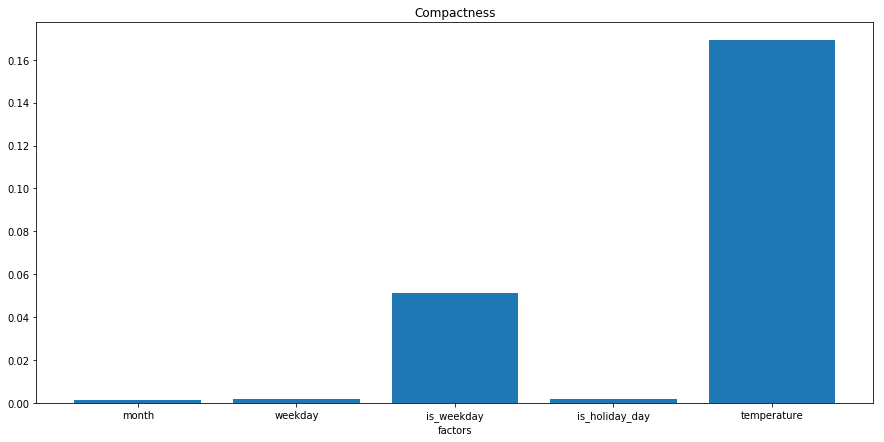

In [203]:
plt.figure(figsize=(15,7))
plt.bar(factorDesc.keys(),model_eval['compactness'])
plt.xlabel('factors')
plt.title('Compactness');

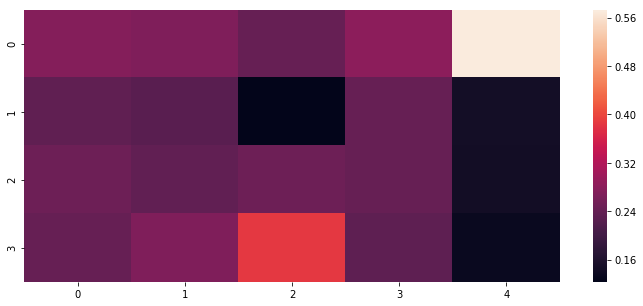

In [204]:
plt.figure(figsize=(12,5))
sn.heatmap(importanceMatrix);


# reconstruction error analysis

In [34]:
error=np.sum(np.abs((x - x_hat)),axis=1)/48

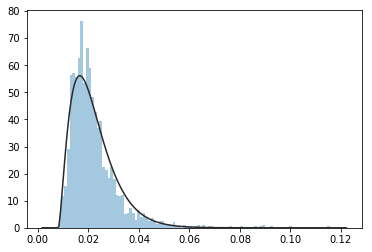

In [35]:
#make a histogram over residuals
import seaborn as sn
sn.distplot(error, kde=False, fit=stats.gamma, bins=100)

Check the day with errors above a threshold

In [48]:
ErrorThreshold=0.05
idxMaxError=[i for i in range(0,nPoints) if error[i]>=ErrorThreshold]
calender_error=calendar_info.loc[idxMaxError]
calender_error['error']=error[idxMaxError]

calender_error

,ds,month,weekday,is_weekday,is_holiday_day,snow,floods,storm,hurricane,rain,cold,hot,error
3,2012-12-31,12,0,1,0.0,0,0,0,0,0,0,0,0.055099
21,2013-01-18,1,4,1,0.0,1,1,0,0,1,1,0,0.051296
59,2013-02-25,2,0,1,0.0,1,0,0,0,0,0,0,0.056004
63,2013-03-01,3,4,1,0.0,0,0,0,0,0,0,0,0.050599
93,2013-03-31,3,6,0,0.0,1,0,0,0,0,1,0,0.092935
123,2013-04-30,4,1,1,0.0,0,0,0,0,0,0,0,0.052637
362,2013-12-25,12,2,1,1.0,0,1,0,1,1,0,0,0.069279
770,2015-02-06,2,4,1,0.0,1,0,0,0,0,1,0,0.051829
796,2015-03-04,3,2,1,0.0,0,0,0,0,0,0,0,0.050755
821,2015-03-29,3,6,0,0.0,1,0,0,1,1,0,0,0.085978


Check the first n days with highest errors 

In [49]:
nDays=30

decreasingOrderIdx=np.argsort(-error)
calendar_Error_Highest=calendar_info.loc[decreasingOrderIdx[0:nDays]]
calendar_Error_Highest['error']=error[decreasingOrderIdx[0:nDays]]
calendar_Error_Highest

,ds,month,weekday,is_weekday,is_holiday_day,snow,floods,storm,hurricane,rain,cold,hot,error
1465,2017-01-01,1,6,0,1.0,0,0,0,0,0,0,0,0.115542
1822,2017-12-24,12,6,0,0.0,0,0,0,0,0,0,0,0.100069
93,2013-03-31,3,6,0,0.0,1,0,0,0,0,1,0,0.092935
1414,2016-11-11,11,4,1,1.0,0,0,0,0,0,0,0,0.089107
1828,2017-12-30,12,5,0,0.0,0,0,0,0,0,0,0,0.088785
1808,2017-12-10,12,6,0,0.0,1,0,0,1,0,0,0,0.088037
821,2015-03-29,3,6,0,0.0,1,0,0,1,1,0,0,0.085978
1758,2017-10-21,10,5,0,0.0,0,0,0,0,0,0,1,0.080951
1823,2017-12-25,12,0,1,1.0,0,0,0,0,0,0,0,0.076242
362,2013-12-25,12,2,1,1.0,0,1,0,1,1,0,0,0.069279


Visualize the reconstruction error over a specific day

Text(0.5, 1.0, '0.05376145583649273')

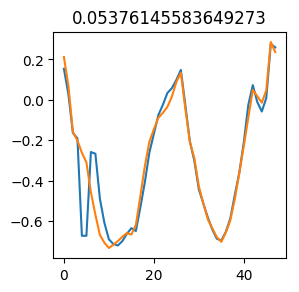

In [50]:
indice=1185 #1185 is the changing hour day end of march
fig = plt.figure(dpi=100,figsize=(3,3))
#set(gca,'Color','k')
plt.plot(x[indice,:])
plt.plot(x_hat[indice,:])
plt.title(error[indice])

In [51]:
calender_error.head()

,ds,month,weekday,is_weekday,is_holiday_day,snow,floods,storm,hurricane,rain,cold,hot,error
3,2012-12-31,12,0,1,0.0,0,0,0,0,0,0,0,0.055099
21,2013-01-18,1,4,1,0.0,1,1,0,0,1,1,0,0.051296
59,2013-02-25,2,0,1,0.0,1,0,0,0,0,0,0,0.056004
63,2013-03-01,3,4,1,0.0,0,0,0,0,0,0,0,0.050599
93,2013-03-31,3,6,0,0.0,1,0,0,0,0,1,0,0.092935


Visualize the reconstruction error over the days with highest error

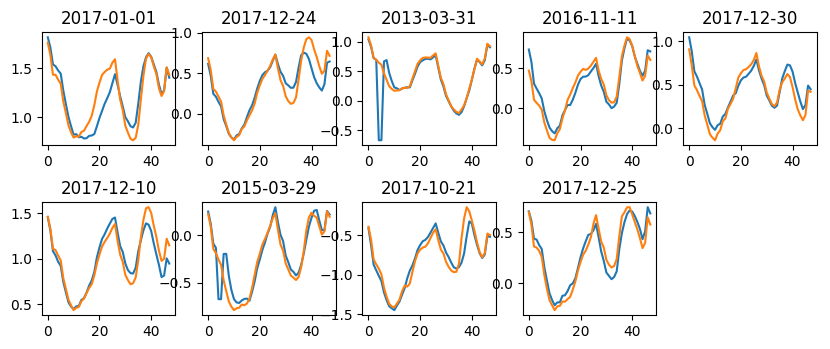

In [52]:
nPlots=10#len(idxMaxError)
nCols=5
nRows=int(nPlots/nCols)+1
fig = plt.figure(dpi=100,figsize=(10,nRows*2))
for i in range(1, nPlots):
    plt.subplot(nRows, nCols, i)
    fig.subplots_adjust(hspace=.5)
    indice=decreasingOrderIdx[i-1]
    plt.plot(x[indice,:])
    plt.plot(x_hat[indice,:])
    plt.title( calendar_Error_Highest.ds.dt.date.iloc[i-1])

2013-03-31 is the day with a missing hour because of changing day time and the consumption value is set to 0. It is hence normal that it is not well predicted and a good indicator that the model does not tend to overfit.

# Study of holiday predictions

In [53]:
#preparation des features d'interet
yHd=calendar_info['is_holiday_day'].astype(int)
indicesHd=np.array([i for i in range(0, nPoints) if yHd[i] == 1])
yHd_only=yHd[yHd==1]
x_encoded_Hd=x_encoded[indicesHd,]

In [54]:
results_hd=scoreKnnResults(x_encoded,yHd,type='classifier',k=5,cv=10)

## holidays well predicted and not

In [55]:
results_hd_only=[results_hd['predP'][i] for i in indicesHd ]
indices_Hd_predict=[i for i in indicesHd if  results_hd['predP'][i]>=0.5]
indices_Hd_not_predicted=[i for i in indicesHd if  results_hd['predP'][i]<0.5]
calendar_info.loc[indices_Hd_predict]

,ds,month,weekday,is_weekday,is_holiday_day,snow,floods,storm,hurricane,rain,cold,hot
4,2013-01-01,1,1,1,1.0,0,0,0,0,0,0,0
124,2013-05-01,5,2,1,1.0,0,0,0,0,0,0,0
131,2013-05-08,5,2,1,1.0,0,0,0,0,0,0,0
132,2013-05-09,5,3,1,1.0,0,0,0,0,0,0,0
143,2013-05-20,5,0,1,1.0,1,0,0,0,0,1,0
230,2013-08-15,8,3,1,1.0,0,0,0,0,0,0,0
308,2013-11-01,11,4,1,1.0,0,0,0,0,0,0,0
362,2013-12-25,12,2,1,1.0,0,1,0,1,1,0,0
369,2014-01-01,1,2,1,1.0,0,0,0,0,0,0,0
479,2014-04-21,4,0,1,1.0,0,0,0,0,0,0,0


In [56]:
len(indices_Hd_predict)

33

In [57]:

calendar_info.loc[indices_Hd_not_predicted]

,ds,month,weekday,is_weekday,is_holiday_day,snow,floods,storm,hurricane,rain,cold,hot
94,2013-04-01,4,0,1,1.0,1,0,0,0,0,1,0
198,2013-07-14,7,6,0,1.0,0,0,0,0,0,0,0
318,2013-11-11,11,0,1,1.0,0,0,0,0,0,0,0
673,2014-11-01,11,5,0,1.0,0,0,0,0,0,0,1
683,2014-11-11,11,1,1,1.0,0,0,0,0,0,0,0
829,2015-04-06,4,0,1,1.0,0,0,0,0,0,0,0
960,2015-08-15,8,5,0,1.0,0,0,0,0,0,0,0
1038,2015-11-01,11,6,0,1.0,0,1,0,1,1,0,1
1220,2016-05-01,5,6,0,1.0,0,0,0,0,0,0,0
1227,2016-05-08,5,6,0,1.0,0,0,0,0,0,0,0


In [58]:
len(indices_Hd_not_predicted)

12

Days not predicted are mostly days on weekends except for  2013-04-01, 2013-11-01, 2014-05-08, 2015-05-08 which are similar to some holidays but also to non-working days. They could hence be predicted as non-working days which is fine

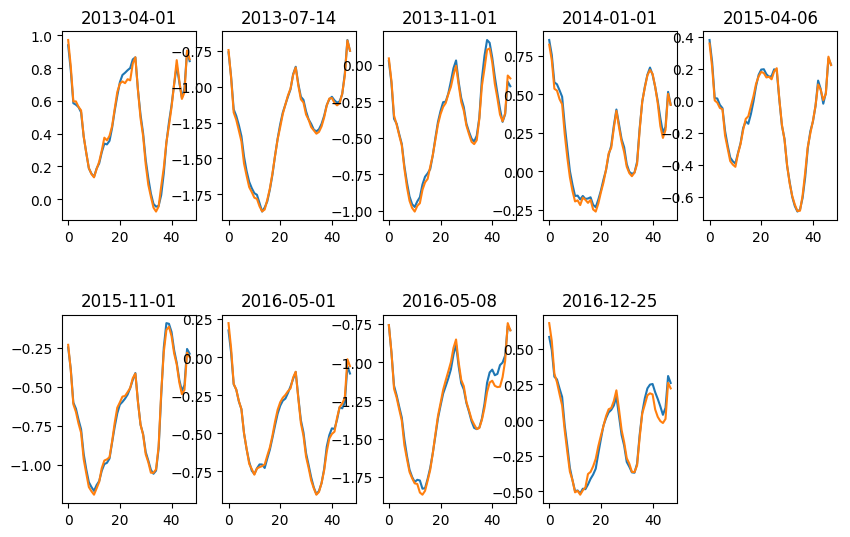

In [46]:
nPlots=10#len(idxMaxError)
nCols=5
nRows=int(nPlots/nCols)+1
fig = plt.figure(dpi=100,figsize=(10,10))
for i in range(1, nPlots):
    plt.subplot(nRows, nCols, i)
    fig.subplots_adjust(hspace=.5)
    indice=indices_Hd_not_predicted[i-1]
    plt.plot(x[indice,:])
    plt.plot(x_hat[indice,:])
    plt.title( calendar_info.ds.dt.date.iloc[indice])

# Detect Events as local outliers

<function matplotlib.pyplot.show(*args, **kw)>

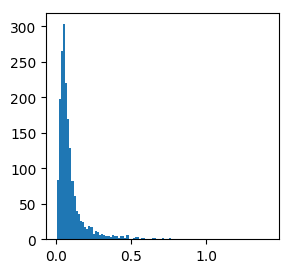

In [59]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(10)
neigh.fit(x_encoded)

[distance_knn,kneighbors]=neigh.kneighbors(x_encoded, 2, return_distance=True)
nearest=distance_knn[:,1]
fig = plt.figure(dpi=100,figsize=(3,3))
plt.hist(nearest,bins=100)
plt.show

In [60]:
from scipy import stats

stats.describe(nearest)

DescribeResult(nobs=1830, minmax=(0.006932847435333935, 1.4091671716540162), mean=0.09970467872782217, variance=0.012924850315898148, skewness=4.457521728296224, kurtosis=29.777742915133118)

<function matplotlib.pyplot.show(*args, **kw)>

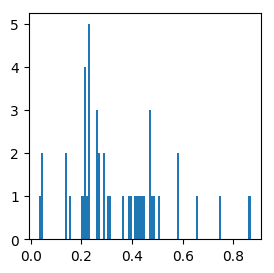

In [61]:
fig = plt.figure(dpi=100,figsize=(3,3))
plt.hist(nearest[indicesHd],bins=100)
plt.show

In [62]:
stats.describe(nearest[indicesHd])

DescribeResult(nobs=45, minmax=(0.033335000878423206, 0.8673776191412851), mean=0.3354147242064339, variance=0.03185335580841869, skewness=0.7597901776174124, kurtosis=0.64216579981565)

In [65]:
nearestThreshold=0.7
calendar_info.iloc[np.where(nearest>=nearestThreshold)]

,ds,month,weekday,is_weekday,is_holiday_day,snow,floods,storm,hurricane,rain,cold,hot
5,2013-01-02,1,2,1,0.0,0,0,0,0,0,0,0
361,2013-12-24,12,1,1,0.0,0,1,0,1,1,0,0
724,2014-12-22,12,0,1,0.0,0,0,0,0,0,0,0
726,2014-12-24,12,2,1,0.0,1,0,0,0,0,1,0
1091,2015-12-24,12,3,1,0.0,0,0,0,0,0,0,1
1203,2016-04-14,4,3,1,0.0,0,0,0,0,0,0,0
1414,2016-11-11,11,4,1,1.0,0,0,0,0,0,0,0
1458,2016-12-25,12,6,0,1.0,0,0,0,0,0,0,0
1466,2017-01-02,1,0,1,0.0,0,0,0,0,0,0,0
1491,2017-01-27,1,4,1,0.0,1,0,0,1,0,1,0


2013-03-11 and 2017-01-26/27 were big snowy events in France. 2013-04-14 was a punctual summer day in early spring. 2014-02-06 was a stormy day. Other days are either holidays or similar non-working days which can be analysed in the projector.

In [56]:
indicesNear=[i for i in range(0,len(nearest)) if nearest[i]>=nearestThreshold]
nearest[np.where(nearest>=nearestThreshold)]

array([0.52811785, 0.68375602, 0.5303795 , 0.59741247, 0.51475207,
       0.54713014, 0.64357289, 1.00325979, 0.53516124, 0.76032559,
       0.70309625])

<bound method Figure.show of <Figure size 1000x600 with 11 Axes>>

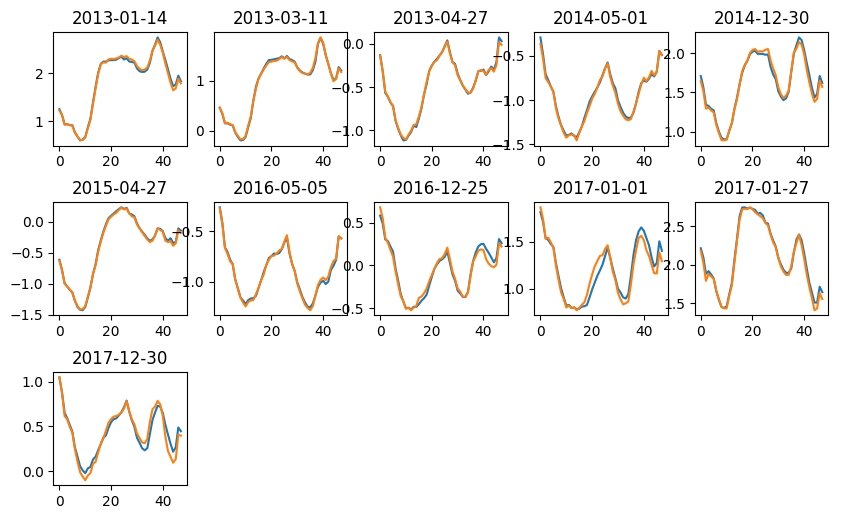

In [57]:
nPlots=len(indicesNear)#len(idxMaxError)
nCols=5
nRows=int(nPlots/nCols)+1
fig = plt.figure(dpi=100,figsize=(10,nRows*2))
for i in range(1, nPlots+1):
    plt.subplot(nRows, nCols, i)
    fig.subplots_adjust(hspace=.5)
    indice=indicesNear[i-1]
    plt.plot(x[indice,:])
    plt.plot(x_hat[indice,:])
    plt.title( calendar_info.ds.dt.date.iloc[indice])
fig.show

In [66]:
from sklearn.cluster import SpectralClustering

clt = SpectralClustering(n_clusters=16,affinity='nearest_neighbors', n_neighbors=5, n_init=50)
clt.fit(x_encoded)
spec_clt = clt.labels_

for i in np.unique(spec_clt):
    indix = np.where(spec_clt==i)
    TTH = np.sum(calendar_info.iloc[indix]['is_holiday_day'])
    print("group ", i," : is_holiday", TTH, " - is not : ", calendar_info.iloc[indix].shape[0]-TTH)

group  0  : is_holiday 3.0  - is not :  91.0
group  1  : is_holiday 0.0  - is not :  173.0
group  2  : is_holiday 0.0  - is not :  130.0
group  3  : is_holiday 0.0  - is not :  58.0
group  4  : is_holiday 0.0  - is not :  199.0
group  5  : is_holiday 4.0  - is not :  149.0
group  6  : is_holiday 0.0  - is not :  135.0
group  7  : is_holiday 7.0  - is not :  0.0
group  8  : is_holiday 1.0  - is not :  98.0
group  9  : is_holiday 23.0  - is not :  59.0
group  10  : is_holiday 1.0  - is not :  122.0
group  11  : is_holiday 0.0  - is not :  161.0
group  12  : is_holiday 0.0  - is not :  136.0
group  13  : is_holiday 0.0  - is not :  141.0
group  14  : is_holiday 0.0  - is not :  123.0
group  15  : is_holiday 16.0  - is not :  0.0


In [67]:
ind_ = np.where(spec_clt==9)
ind_ = [ind_[0][i] for i in range(len(ind_[0])) ]#if calendar_info['is_holiday_day'].loc[ind_[0][i]]==0]
calendar_info.loc[ind_]

,ds,month,weekday,is_weekday,is_holiday_day,snow,floods,storm,hurricane,rain,cold,hot
0,2012-12-28,12,4,1,0.0,0,0,0,0,0,0,0
3,2012-12-31,12,0,1,0.0,0,0,0,0,0,0,0
4,2013-01-01,1,1,1,1.0,0,0,0,0,0,0,0
5,2013-01-02,1,2,1,0.0,0,0,0,0,0,0,0
6,2013-01-03,1,3,1,0.0,0,0,0,0,0,0,0
7,2013-01-04,1,4,1,0.0,0,0,0,0,0,0,0
10,2013-01-07,1,0,1,0.0,0,0,0,0,0,0,0
17,2013-01-14,1,0,1,0.0,1,1,0,0,1,1,0
36,2013-02-02,2,5,0,0.0,0,0,0,1,1,0,0
73,2013-03-11,3,0,1,0.0,1,0,0,1,0,1,0


In [68]:
np.unique(calendar_info['month'].loc[ind_], return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8, 11, 12]),
 array([16,  2,  2,  2,  7,  2,  5,  2, 11, 33]))

<bound method Figure.show of <Figure size 1000x800 with 16 Axes>>

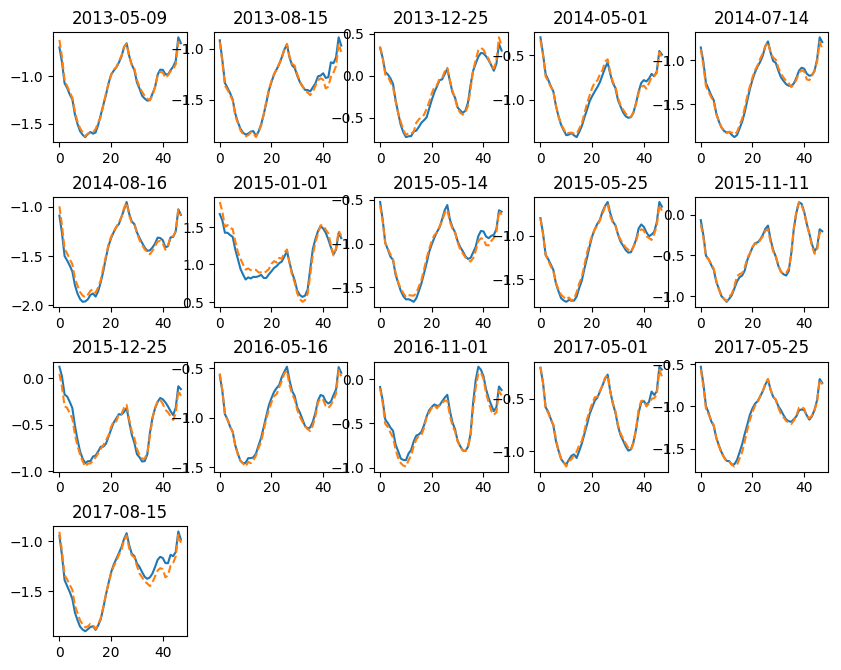

In [88]:
nPlots=len(ind_[0])#len(idxMaxError)
nCols=5
nRows=int(nPlots/nCols)+1
fig = plt.figure(dpi=100,figsize=(10,nRows*2))
for i in range(1, nPlots+1):
    plt.subplot(nRows, nCols, i)
    fig.subplots_adjust(hspace=.5)
    indice=ind_[0][i-1]
    plt.plot(x[indice,:])
    plt.plot(x_hat[indice,:],'--')
    plt.title( calendar_info.ds.dt.date.iloc[indice])
fig.show

In [1]:
from sklearn.cluster import AgglomerativeClustering

clt = AgglomerativeClustering(n_clusters=33)
clt.fit(x_encoded)
spec_clt = clt.labels_

for i in np.unique(spec_clt):
    indix = np.where(spec_clt==i)
    TTH = np.sum(calendar_info.iloc[indix]['is_holiday_day'])
    decomposition, counts = np.unique(calendar_info['month'].loc[indix], return_counts=True)
    month_imp = decomposition[np.argsort(counts)[::-1]]
    print("group ", i," : is_holiday", TTH, " - is not : ", calendar_info.iloc[indix].shape[0]-TTH, month_imp)

NameError: name 'x_encoded' is not defined

In [85]:
ind_ = np.where(spec_clt==1)
ind_ = [ind_[0][i] for i in range(len(ind_[0])) if calendar_info['is_holiday_day'].loc[ind_[0][i]]==0]
print(len(ind_))
calendar_info.loc[ind_]

34


,ds,month,weekday,is_weekday,is_holiday_day,snow,floods,storm,hurricane,rain,cold,hot
0,2012-12-28,12,4,1,0.0,0,0,0,0,0,0,0
5,2013-01-02,1,2,1,0.0,0,0,0,0,0,0,0
6,2013-01-03,1,3,1,0.0,0,0,0,0,0,0,0
7,2013-01-04,1,4,1,0.0,0,0,0,0,0,0,0
360,2013-12-23,12,0,1,0.0,0,1,0,1,1,0,0
363,2013-12-26,12,3,1,0.0,0,1,0,1,1,0,0
364,2013-12-27,12,4,1,0.0,0,0,0,0,0,0,0
367,2013-12-30,12,0,1,0.0,0,0,0,0,0,0,0
370,2014-01-02,1,3,1,0.0,0,0,0,0,0,0,0
371,2014-01-03,1,4,1,0.0,0,0,0,0,0,0,0


On repère ici le groupe des vacances de Noël.

In [87]:
ind_ = np.where(spec_clt==7)
ind_ = [ind_[0][i] for i in range(len(ind_[0])) if calendar_info['is_holiday_day'].loc[ind_[0][i]]==0]
calendar_info.loc[ind_]

,ds,month,weekday,is_weekday,is_holiday_day,snow,floods,storm,hurricane,rain,cold,hot
76,2013-03-14,3,3,1,0.0,1,0,0,1,0,1,0
79,2013-03-17,3,6,0,0.0,1,0,0,0,1,0,0
81,2013-03-19,3,1,1,0.0,0,0,0,0,0,0,0
155,2013-06-01,6,5,0,0.0,0,1,0,0,1,0,0
156,2013-06-02,6,6,0,0.0,0,0,0,0,0,0,0
295,2013-10-19,10,5,0,0.0,0,0,0,0,0,0,1
361,2013-12-24,12,1,1,0.0,0,1,0,1,1,0,0
432,2014-03-05,3,2,1,0.0,0,0,0,0,0,0,0
435,2014-03-08,3,5,0,0.0,0,0,0,0,0,0,1
455,2014-03-28,3,4,1,0.0,0,0,0,0,0,0,0


# Conclusions
- We managed to properly condition on the expert feature passed as the residual latent space is almost independant from them
- We recover holidays which are well-represented and can be predicted
- We can use the latent projection to discover other non-working days to label such as days near holidays or Christmas week
- When looking at local outliers, we discover first weather events to further analyze in a more appropriate conditional representation were they are better represented.


